# 【問題1】機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。


keras/lstm_seq2seq.py at master · keras-team/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


（コードリーディング回答）
- 44から48行目 : ライブラリ関係のimport
- 50から53行目 : ハイパーパラメータの設定
- 55行目 ： データパス
- 62から63行目 : データ読み込み、改行で分割
- 64行目 ： 1行ずつデータ取り出し
- 65行目 ： タブでデータ分割
- 68行目 ： target_textの先頭にタブ、末尾に改行をプラス
- 68行目 ： target_textの先頭にタブ、末尾に改行をプラス
- 69から70行目 : input,targetをリストにappend
- 71から76行目 : ユニークな文字の抽出
- 78から89行目 : ソート、文字数、最大単語長の確認と出力
- 91から94行目 : 文字のindex化
- 96から104行目 : 容器の準備
- 12０から124行目 : 入力シーケンス定義し、状態のみを保持
- 127から135行目 : デコーダーの定義
- 139から149行目 : 学習モデル定義、compile、fit、save
- 160から171行目 : 推論モデル定義
- 181から216行目 : デコードシーケンス関数でデコード処理
- 219から226行目 : input、decord センテンスを出力

In [ ]:
!nvidia-smi

Fri Oct  9 02:04:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cd /content/drive/My Drive/Sprint Seq2Seq

/content/drive/My Drive/Sprint Seq2Seq


In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-10-09 01:57:46--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.108.196, 104.24.109.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6073837 (5.8M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.79M  18.7MB/s    in 0.3s    

2020-10-09 01:57:46 (18.7 MB/s) - ‘fra-eng.zip’ saved [6073837/6073837]



In [ ]:
pwd

'/content/drive/My Drive/Sprint Seq2Seq'

In [ ]:
!unzip /content/drive/'My Drive'/'Sprint Seq2Seq'/fra-eng.zip  -d fra-eng

Archive:  /content/drive/My Drive/Sprint Seq2Seq/fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [ ]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '/content/drive/My Drive/Sprint Seq2Seq/fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 2s 16ms/step - loss: 1.1784 - accuracy: 0.7249 - val_loss: 1.0742 - val_accuracy: 0.7109
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8546 - accuracy: 0.7709 - val_loss: 0.8505 - val_accuracy: 0.7618
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.6830 - accuracy: 0.8074 - val_loss: 0.7243 - val_accuracy: 0.7921
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5958 - accuracy: 0.8277 - val_loss: 0.6639 - val_accuracy: 0.8054
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5439 - accuracy: 0.8413 - val_loss: 0.6117 - val_accuracy: 0.8208
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5069 - accuracy: 0.8513 - val_loss: 0

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [ ]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2020-10-09 02:18:56--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-10-09 02:18:56--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbdd5dcb2f9689493d1b2bd2d3d.dl.dropboxusercontent.com/cd/0/inline/BA5RiioBCYPeY0xeAVyD76-zb0YclPCvwNXzoJYDHtn9aAiJUjVjyK9f9vwvtyjloz82f2OQ7mDlOVsWecosFaZelHFlUcav3GFArd-GhBekEYjZfMfgTAjMrHsgx0_fr88/file# [following]
--2020-10-09 02:18:56--  https://ucbdd5dcb2f9689493d1b2bd2d3d.dl.dropboxusercontent.com/cd/0/inline/BA5RiioBCYPeY0xeAVyD76-zb0YclPCvwNXzoJYDHtn9aAiJUjVjyK9f9vwvtyjloz82f2OQ7mDlOVsWec

In [ ]:
!unzip /content/drive/'My Drive'/'Sprint Seq2Seq'/pretrained_model.zip?dl=0  -d pretrained_model

Archive:  /content/drive/My Drive/Sprint Seq2Seq/pretrained_model.zip?dl=0
  inflating: pretrained_model/encoder-5-3000.pkl  
  inflating: pretrained_model/decoder-5-3000.pkl  


In [ ]:
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2020-10-09 02:52:13--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2020-10-09 02:52:13--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e511aa82ac7afec6ddba03491.dl.dropboxusercontent.com/cd/0/inline/BA7yW1aD5XcWbLCnXtwmrEjJzZIRpYGzwtvn1k7EuAraVVjQg7ByfBKSn3rXZYJMn-eSgb0yjU-4QUAqmL2qyuVMipAT5xJF4Ks-njlupCNyUrb_e-Ji-V-_TYdPsfRNvzk/file# [following]
--2020-10-09 02:52:14--  https://uc1e511aa82ac7afec6ddba03491.dl.dropboxusercontent.com/cd/0/inline/BA7yW1aD5XcWbLCnXtwmrEjJzZIRpYGzwtvn1k7EuAraVVjQg7ByfBKSn3rXZYJMn-eSgb0yjU-4QUAqmL2qyuVMipAT5xJF4Ks-njlupCNyUrb_e-J

In [ ]:
!unzip /content/drive/'My Drive'/'Sprint Seq2Seq'/vocap.zip?dl=0  -d vocap

Archive:  /content/drive/My Drive/Sprint Seq2Seq/vocap.zip?dl=0
  inflating: vocap/vocab.pkl         


In [ ]:
mv ./pretrained_model/decoder-5-3000.pkl ./pretrained_model/models/

In [ ]:
mv ./pretrained_model/encoder-5-3000.pkl ./pretrained_model/models/

In [ ]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 917, done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 917
Receiving objects: 100% (917/917), 12.80 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (491/491), done.


In [ ]:
cd /content/drive/My Drive/Sprint Seq2Seq/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/drive/My Drive/Sprint Seq2Seq/pytorch-tutorial/tutorials/03-advanced/image_captioning


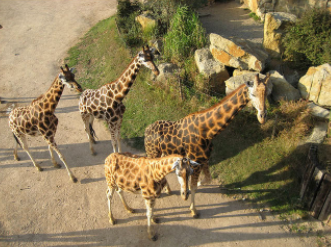

In [ ]:
from IPython.display import Image,display_png

#入力画像1
display_png(Image('png/example.png'))

In [ ]:
#出力結果（文字）１
!python sample.py --image='png/example.png'

<start> a group of giraffes standing next to each other . <end>


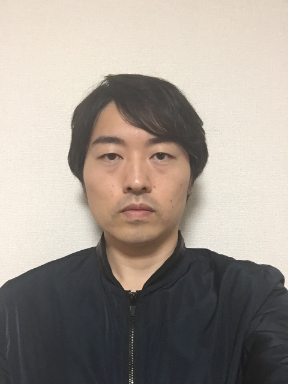

In [ ]:
#入力画像2
display_png(Image('png/IMG_2632.png'))

In [ ]:
#出力結果（文字）2
!python sample.py --image='png/IMG_2632.png'

<start> a man wearing a suit and tie with a tie . <end>


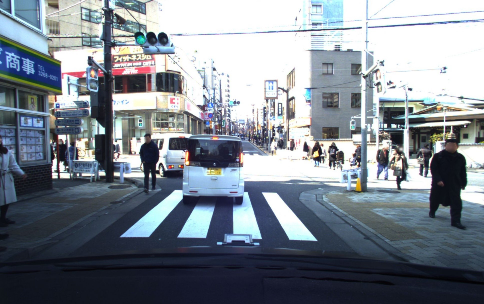

In [ ]:
#入力画像3
display_png(Image('png/train_0397.png'))

In [ ]:
#出力結果（文字）3
!python sample.py --image='png/train_0397.png'

<start> a city street with a lot of cars and cars . <end>


# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

《流れ》<br>
PyTorchモデル → ONNX形式に変換 → Keras形式に変換

※覚書き<br>
ONNXはOpen Neural Network eXchangeの略で、DeepLearningモデルを様々なフレームワーク間で交換するためのフォーマットです。
これを使えばあるDeepLearningフレームワークで学習させたモデルを他のフレームワークでも利用することができます。DeepLearningフレームワーク戦国時代には嬉しい仕組みです。
ちなみにONNXは「オニキス」と発音します。

##### 変換コードイメージ
参考資料：[PyTorchで学習したモデルをTFLiteモデルに変換して使う](https://qiita.com/lain21/items/9f9f9707ebad4bbc627d)

In [ ]:
#PyTorchモデル →　ONNX形式へ変換

# モデルの初期化と学習済み重みの読み込み
model = model()
state_dict = torch.load('weight_path') #重みの読み込み
model.load_state_dict(state_dict)
model.convert_se()

# ONNX形式でのモデルの保存
onnx_model_path = './data/model.onnx'
dummy_input = torch.randn(1, 3, 224, 224) #ダミーの入力
input_names = ['image_array']  # ここで指定する名前が、後々saved_model.pbにする時のinput名になる
output_names = ['category']    # ここで指定する名前が、後々saved_model.pbにする時のoutput名になる

torch.onnx.export(model, dummy_input, onnx_model_path,
                  input_names=input_names, output_names=output_names)


#ONNX形式 → Keras形式に変換

import onnx
from onnx2keras import onnx_to_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

onnx_model = onnx.load('./data/model.onnx')
input_names = ['image_array']

#onnx_to_kerasでKeras形式に変換
k_model = onnx_to_keras(onnx_model=onnx_model, input_names=input_names)

# 【問題4】（アドバンス課題）コードリーディングと書き換え
モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

### 回答無し

# 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》


問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。


《機械翻訳の発展的手法にはどのようなものがある？》


機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。


《文章から画像生成するには？》


イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

### 回答無し